#### Goals: 
- choose typical test cases (normal distribution, non-normal distribution, quantitative metric, qualitative metric)
- Do the testing
- Plot graphs  
- Make a conclusion  

In [1]:
# TODO: replace synthetic simplified data with real noisy data

## Task 1
The conversion of control and test samples from the same general population is known (normal distribution, quality metric) 

In [1]:
import os
import sys
import datetime as dt

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats

In [2]:
# Control sample size
cont_count = 1000
cont_conv = 410

# Test sample size
test_count = 980
test_conv = 450

In [3]:
cont_count, cont_conv_count = 16500, 30 
test_count, test_conv_count = 17000, 50

In [5]:
# Conversion values
cont_conv = cont_conv_count / cont_count
test_conv = test_conv_count / test_count

# Conversion variance values
cont_conv_var = cont_conv*(1-cont_conv)/cont_count
# or equal test_dist.std()**2
test_conv_var = test_conv*(1-test_conv)/test_count
# or equal test_dist.std()**2

In [6]:
# Generation of control and test samples with a given conversion
cont_dist = np.array([True]*cont_conv_count + [False]*(cont_count-cont_conv_count))
np.random.shuffle(cont_dist)
test_dist = np.array([True]*test_conv_count + [False]*(test_count-test_conv_count))
np.random.shuffle(test_dist)

#### T-test
- H0: the true difference between these group means is zero
- HA: the true difference is different from zero

In [7]:
t_value, p_value = stats.ttest_ind(test_dist, cont_dist)

print("Trimmed t-test results:")
print("t-value: {}".format(t_value))
print("p-value: {}".format(p_value))

Trimmed t-test results:
t-value: 2.1053973716468
p-value: 0.035264156994533176


### Analytical method

Normal distribution of control and test samples


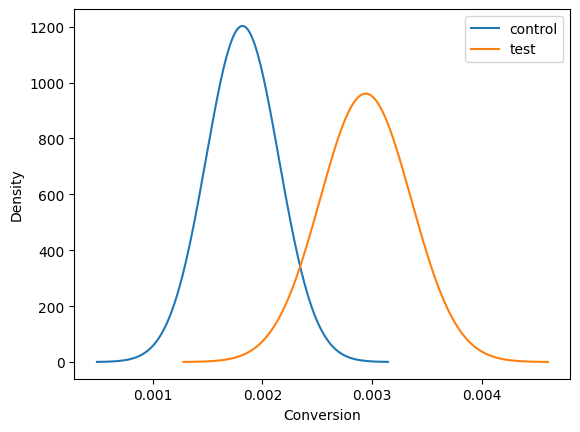

In [8]:
# Create a normal distribution of samples for a given conversion and conversion standard deviation
x_control = np.linspace(cont_conv-np.sqrt(cont_conv_var)*4, cont_conv+np.sqrt(cont_conv_var)*4, 1000)
x_test = np.linspace(test_conv-np.sqrt(test_conv_var)*4, test_conv+np.sqrt(test_conv_var)*4, 1000)

data = np.vstack((x_control, stats.norm.pdf(x_control, cont_conv, np.sqrt(cont_conv_var)), 
                  x_test, stats.norm.pdf(x_test, test_conv, np.sqrt(test_conv_var)),
                 )).T
control_test_df = pd.DataFrame(data, columns=['x', 'control', 'y', 'test'])

print('Normal distribution of control and test samples')
ax = control_test_df.plot(x='x', y='control')
ax = control_test_df.plot(x='y', y='test', ax=ax, xlabel='Conversion', ylabel='Density')

In [23]:
# Find the value of the expected difference in conversions, the standard deviation 
# and the 95% confidence interval 
conv_diff_mean = (test_conv - cont_conv) / cont_conv
conv_diff_std = (cont_conv_var + test_conv_var) ** 0.5
confidence_interval = [conv_diff_mean-conv_diff_std*1.96, conv_diff_mean+conv_diff_std*1.96]

print("Analytical conv diff: {}".format(np.round(conv_diff_mean, 4)))
print("Analytical conv std: {}".format(np.round(conv_diff_std, 4)))
print("Analytical confidence interval (95%): {}".format(np.round(confidence_interval, 4)))

Analytical conv diff: 0.6176
Analytical conv std: 0.0005
Analytical confidence interval (95%): [0.6166 0.6187]


In [22]:
test_conv/cont_conv

1.6176470588235294

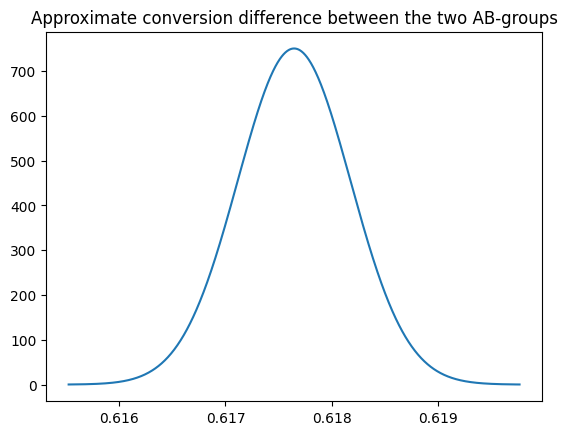

In [24]:
# Plotting the normal distribution given this conversion and standard deviation
x = np.linspace(conv_diff_mean-conv_diff_std*4, conv_diff_mean+conv_diff_std*4, 1000)
ax = pd.DataFrame(stats.norm.pdf(x, conv_diff_mean, conv_diff_std), index=x) \
       .plot(legend=False, title='Approximate conversion difference between the two AB-groups')

# pd.DataFrame(norm.rvs(conv_diff, conv_std, size=1000)).plot(kind='density', legend=False)

### Bootstrap method

Distribution of bootstrap control and test samples


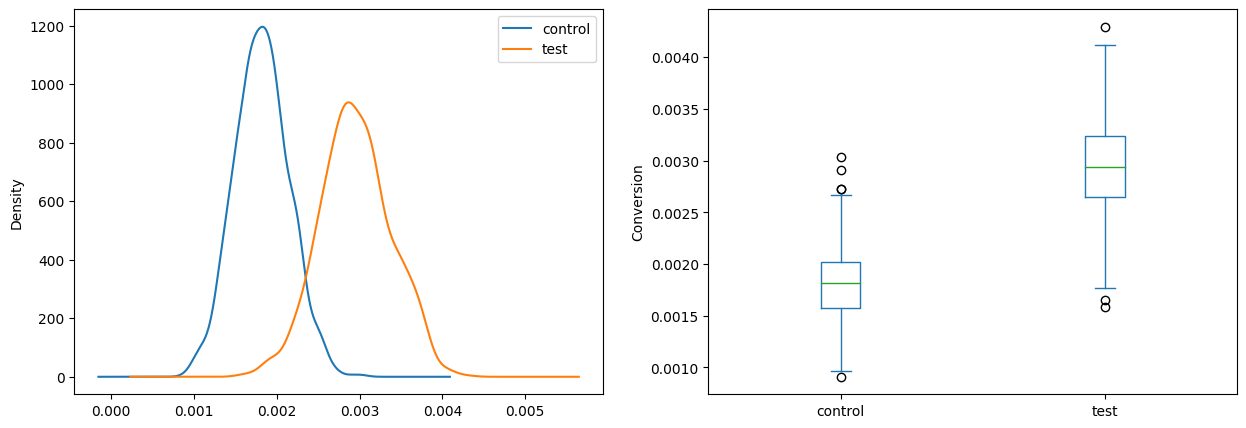

In [11]:
def bootstrap_sample(distribution_list, columns=None, size=1000):
    bootstrap_mean_list = []
    rng = np.random.default_rng()

    for i in range(size):
        bootstrap_item = []
        for dist in distribution_list:
            dist_len = len(dist)
            bootstrap_mean = sum(rng.choice(dist, size=dist_len)) / dist_len
            bootstrap_item.append(bootstrap_mean)
        bootstrap_mean_list.append(bootstrap_item)

    result = pd.DataFrame(bootstrap_mean_list, columns=columns)
    return result

bootstrap_mean_df = bootstrap_sample((cont_dist, test_dist), columns=['control', 'test'], size=1000)

print('Distribution of bootstrap control and test samples')
fig, axs = plt.subplots(ncols=2, figsize=[15, 5])
bootstrap_mean_df.plot(kind='density', ax=axs[0])
bootstrap_mean_df.plot(kind='box', ax=axs[1], ylabel='Conversion')
plt.show()

In [12]:
cont_conv-1.96*np.sqrt(cont_conv_var), cont_conv+1.96*np.sqrt(cont_conv_var)
#x_test = np.linspace(test_conv-np.sqrt(test_conv_var

(0.0011681455595849545, 0.002468218076778682)

Probability that conversion is greater in test sample: 0.983


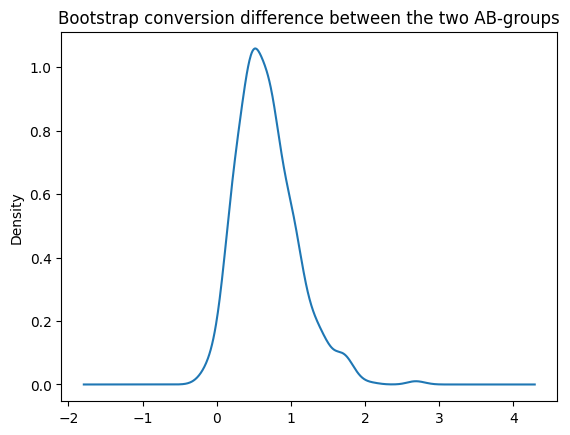

In [25]:
bootstrap_mean_df['diff'] = (bootstrap_mean_df['test']-bootstrap_mean_df['control']) / bootstrap_mean_df['control']

print("Probability that conversion is greater in test sample: {}".format((bootstrap_mean_df['diff'] > 0).mean()))

# Ploting the difference between bootstrap control and test conversion distributions
bootstrap_mean_df['diff'].plot(kind='density', 
                               title='Bootstrap conversion difference between the two AB-groups')
plt.show()

In [26]:
# Find the value of the expected difference in conversions, the standard deviation 
# and the 95% confidence interval 
boot_conv_diff = bootstrap_mean_df['diff'].mean()
boot_conv_std = bootstrap_mean_df['diff'].std()
boot_confidence_interval = [boot_conv_diff-boot_conv_std*t_value, boot_conv_diff+boot_conv_std*t_value]

print("Bootstrap conv diff: {}".format(np.round(boot_conv_diff, 4)))
print("Bootstrap conv std: {}".format(np.round(boot_conv_std, 4)))
print("Bootstrap confidence interval ({}%): {}".format(int((1-p_value)*100), 
                                                       np.round(boot_confidence_interval, 4)))

Bootstrap conv diff: 0.6769
Bootstrap conv std: 0.4077
Bootstrap confidence interval (96%): [-0.1814  1.5351]


In [27]:
print("Conversion change range: {}".format(np.round(np.array(boot_confidence_interval) / cont_conv * 100, 2)))

Conversion change range: [-9979.12 84433.06]


### Conclusion:
Experiments have shown that the value of the conversion change (relative to the control sample) is in the range from 0.05% to 23.96% with a probability of 97 percent (mean is 12%)
Trimmed t-test p-value for bootstrapped samples is ≈0.0274, H0 is rejected (p<0.05)

In [111]:
scipy.stats.chisquare(f_obs=[795, 705], f_exp=[750, 750])

Power_divergenceResult(statistic=5.4, pvalue=0.02013675155034633)

## Task 2
(not normal distribution, quantitative metric)

In [82]:
# TODO: think of a problem and solve it (not normal distribution, quantitative metric)
group1 = [20, 23, 21, 25, 18, 17, 18, 24, 20, 24, 23, 19]
group2 = [24, 25, 21, 22, 23, 18, 17, 28, 24, 27, 21, 23]
stats.mannwhitneyu(group1, group2, alternative='two-sided')

MannwhitneyuResult(statistic=50.0, pvalue=0.21138945901258455)

<AxesSubplot:>

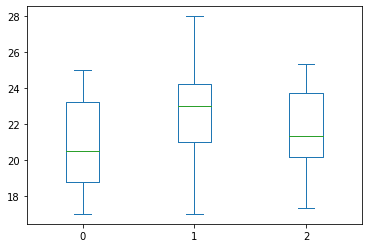

In [93]:
pd.DataFrame(np.vstack((group1, group2, group3)).T).plot(kind='box')

<AxesSubplot:>

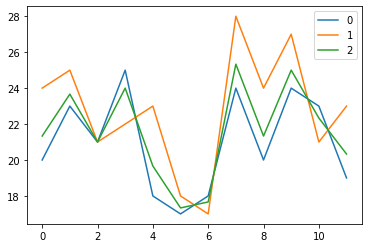

In [94]:
pd.DataFrame(np.vstack((group1, group2, group3)).T).plot()

In [97]:
stats.ttest_ind(group1, group3)

Ttest_indResult(statistic=-0.5338861052204245, pvalue=0.5987740349755029)

In [231]:
x = np.linspace(0, 20, 41)
x

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ])

<AxesSubplot:>

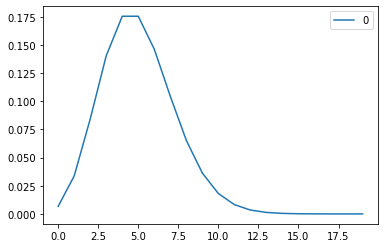

In [61]:
x = [i for i in range(0, 20)]
mu = 5

#plt.plot(x, stats.poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
pd.DataFrame(stats.poisson.pmf(x, mu), index=x).plot()

In [64]:
print(np.round(stats.poisson.pmf(x, mu), 4))
print(x)

[0.0067 0.0337 0.0842 0.1404 0.1755 0.1755 0.1462 0.1044 0.0653 0.0363
 0.0181 0.0082 0.0034 0.0013 0.0005 0.0002 0.     0.     0.     0.    ]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


<AxesSubplot:>

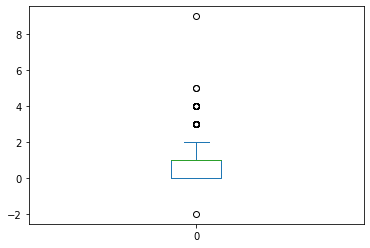

In [56]:
mu = 0.9
control = stats.poisson.rvs(mu, size=1000)
control = np.hstack((control, [9, -2]))
pd.DataFrame(control).plot(kind='box')

In [53]:
np.hstack((control, [9, -1])).max()

9

<AxesSubplot:ylabel='Density'>

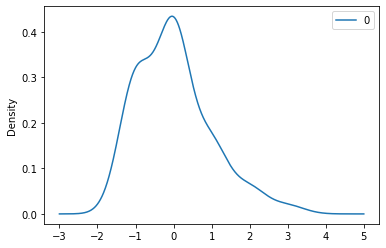

In [58]:
mu = 1
test = stats.poisson.rvs(mu, loc=-1, size=50)
pd.DataFrame(test).plot(kind='density')

In [38]:
stats.poisson.rvs(2, loc=1, size=50).mean()

3.08

<AxesSubplot:ylabel='Density'>

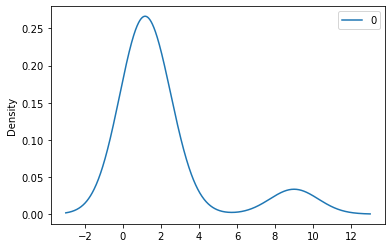

In [5]:
pd.DataFrame([1]*20+[2]*5+[9]*3).plot(kind='density')

In [74]:
np.vstack((norm.rvs(1, 2, size=1000), norm.rvs(5, 1, size=1000)))

array([[ 1.51549753,  3.38838155,  1.98285566, ...,  1.79569464,
        -0.03364226,  1.66973607],
       [ 4.83512562,  2.94003359,  4.11474476, ...,  4.84321659,
         4.34208607,  4.98383662]])

<AxesSubplot:ylabel='Density'>

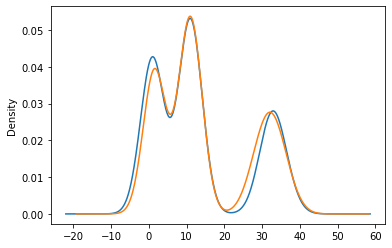

In [181]:
data_a = np.hstack((norm.rvs(1, 1, size=400), norm.rvs(11, 1, size=500), norm.rvs(33, 2, size=300)))
data_b = np.hstack((norm.rvs(1.5, 0.5, size=350), norm.rvs(11, 1, size=500), norm.rvs(32, 3, size=350)))
pd.DataFrame(np.vstack((data_a, data_b)).T).plot(kind='density', legend=False)

<AxesSubplot:>

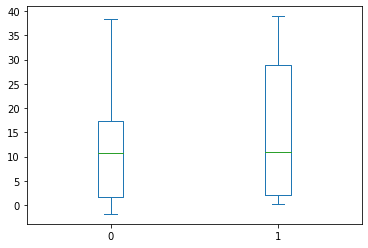

In [182]:
pd.DataFrame(np.vstack((data_a, data_b)).T).plot(kind='box', legend=False)

In [183]:
print(stats.ttest_ind(data_a, data_b))
print(stats.mannwhitneyu(data_a, data_b, alternative='two-sided'))

Ttest_indResult(statistic=-2.436250755549656, pvalue=0.014912729700206314)
MannwhitneyuResult(statistic=660266.0, pvalue=0.00043301807129652085)


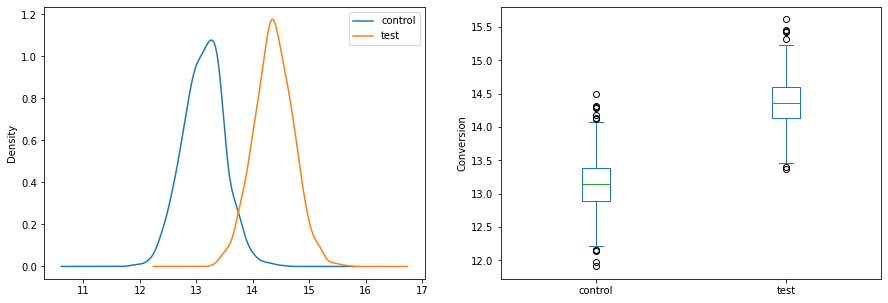

In [184]:
wew = bootstrap_sample((data_a, data_b), columns=['control', 'test'], size=1000)

fig, axs = plt.subplots(ncols=2, figsize=[15, 5])
wew.plot(kind='density', ax=axs[0])
wew.plot(kind='box', ax=axs[1], ylabel='Conversion')
plt.show()

In [185]:
print(stats.ttest_ind(wew['control'], wew['test']))
print(stats.mannwhitneyu(wew['control'], wew['test'], alternative='two-sided'))

Ttest_indResult(statistic=-77.48605864992696, pvalue=0.0)
MannwhitneyuResult(statistic=7566.0, pvalue=0.0)


Probability that conversion is greater in test sample: 0.991


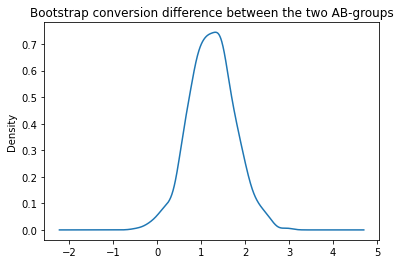

In [186]:
wew['diff'] = wew['test']-wew['control']

print("Probability that conversion is greater in test sample: {}".format((wew['diff'] > 0).mean()))

# Ploting the difference between bootstrap control and test conversion distributions
wew['diff'].plot(kind='density', title='Bootstrap conversion difference between the two AB-groups')
plt.show()

In [213]:
from collections import namedtuple

AB_test_result = namedtuple('AB_test_result', ('statistic', 'pvalue', 'type'))

def ab_test(a, b):
    is_normal_a = stats.shapiro(a)[1] > 0.05
    is_normal_b = stats.shapiro(b)[1] > 0.05
    
    result = []
    
    if is_normal_a and is_normal_b:
        equal_var = stats.levene(a, b)[1] > 0.05
        test_result = stats.ttest_ind(a, b, equal_var=equal_var)
    else:
        test_result = stats.mannwhitneyu(a, b)
        
    result[:2] = test_result
    result.append(type(test_result).__name__)
    
    return AB_test_result(*result)
    
ab_test(bootstrap_mean_df['control'], bootstrap_mean_df['test'])

AB_test_result(statistic=-71.87482695915912, pvalue=0.0, type='Ttest_indResult')

In [299]:
import statsmodels.api as sm

kde = sm.nonparametric.KDEUnivariate(control_test_df[['x']])
kde.fit(control_test_df[['control']])
#plt.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [261]:
scipy.spatial.KDTree(control_test_df[['x', 'control']]).data

array([[0.34778746, 0.00860471],
       [0.34791201, 0.00888451],
       [0.34803656, 0.00917283],
       ...,
       [0.47196344, 0.00917283],
       [0.47208799, 0.00888451],
       [0.47221254, 0.00860471]])

<AxesSubplot:ylabel='Density'>

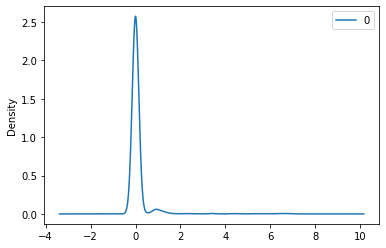

In [379]:
density = stats.gaussian_kde(y)
pd.DataFrame(density.pdf(x)).plot(kind='density')
density.evaluate(x)

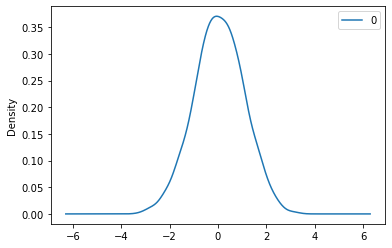

In [389]:
pd.DataFrame(norm.rvs(0, 1, size=1000)).plot(kind='density')
plt.show()

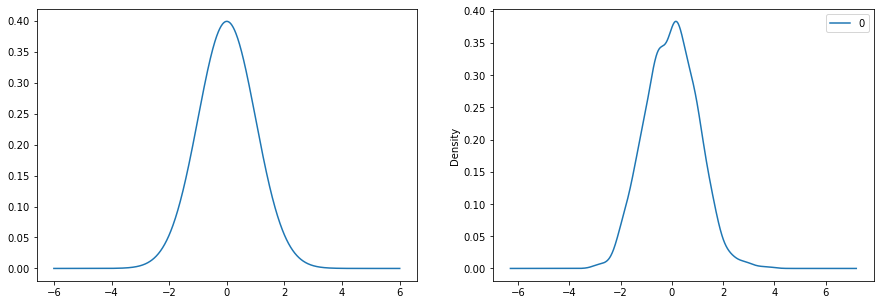

In [433]:
import numpy as np
from scipy import stats

mean = 0
std = 1

x = np.linspace(mean-std*6, mean+std*6, 1000)
y = stats.norm.pdf(x, mean, std)
norm_density = stats.norm.rvs(mean, std, size=1000)

fig, axs = plt.subplots(ncols=2, figsize=[15, 5])
axs[0].plot(x, y)
pd.DataFrame(norm_density).plot(kind='density', ax=axs[1])
plt.show()

<AxesSubplot:ylabel='Density'>

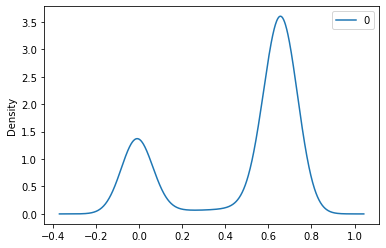

In [369]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree")
kde.fit(data)
pd.DataFrame(kde.score_samples(data)).plot(kind='density')

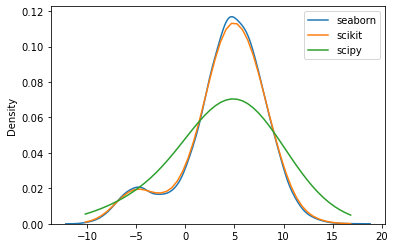

In [402]:
n = 10000
dist_frac = 0.1
x1 = np.random.normal(-5,2,int(n*dist_frac))
x2 = np.random.normal(5,3,int(n*(1-dist_frac)))
x = np.concatenate((x1,x2))
np.random.shuffle(x)
eval_points = np.linspace(np.min(x), np.max(x))

kde_sk = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde_sk.fit(x.reshape([-1,1]))
y_sk = np.exp(kde_sk.score_samples(eval_points.reshape(-1,1)))

kde_sp = stats.gaussian_kde(x, bw_method=1.0)
y_sp = kde_sp.pdf(eval_points)

sns.kdeplot(x)
plt.plot(eval_points, y_sk)
plt.plot(eval_points, y_sp)
plt.legend(['seaborn','scikit','scipy'])

<AxesSubplot:ylabel='Density'>

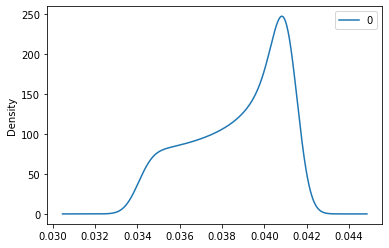

In [478]:
def wew(x: np.ndarray, y: np.ndarray):


    kde_model = KernelDensity(kernel='gaussian', bandwidth=9)
    kde_model.fit(x)
    score = kde_model.score_samples(x)
    return np.exp(score)
pd.DataFrame(wew(x, y)).plot(kind='density')

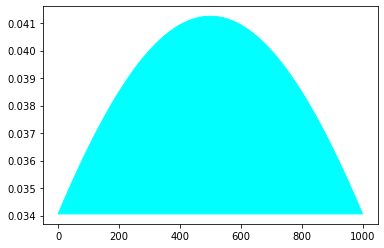

In [480]:
kde = grid.best_estimator_
log_dens = kde.score_samples(x_test)
plt.fill(wew(x, y), c='cyan')

In [474]:
x = np.linspace(-6, 6, 1000).reshape(-1, 1)
y = stats.norm.pdf(x, mean, std)

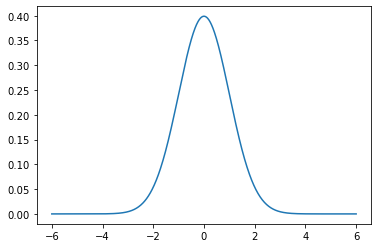

In [470]:
plt.plot(x, y)